In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt

from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
DATASET_NAME = "20230704-dataset"
MODEL = "MobileNetV2"
KERAS_TUNER_PROJECT=f'{MODEL}-{DATASET_NAME}'

TRAIN_PATH = f"./{DATASET_NAME}/train"
VAL_PATH = f"./{DATASET_NAME}/validation"
TEST_PATH = f"./{DATASET_NAME}/test"

LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'
BATCH_SIZE = 32

if MODEL == "MobileNetV2":
  IMAGE_SIZE = (224, 224)
  TL_INPUT_SHAPE = (224, 224, 3)
else: #XCeption
  IMAGE_SIZE = (299, 299) 
  TL_INPUT_SHAPE = (299, 299, 3)

SEED = 80

In [ ]:
# Restart from stractch
import shutil
shutil.rmtree(f'./models/{MODEL}/{DATASET_NAME}', ignore_errors=True)
os.makedirs(f'./models/{MODEL}/{DATASET_NAME}/', exist_ok=True)
shutil.rmtree(f'./tensorboard_logs/{MODEL}/{DATASET_NAME}', ignore_errors=True)
os.makedirs(f'./tensorboard_logs/{MODEL}/{DATASET_NAME}', exist_ok=True)
shutil.rmtree(f'./results/{KERAS_TUNER_PROJECT}', ignore_errors=True)

In [7]:
train_ds = image_dataset_from_directory(
                  TRAIN_PATH,
                  label_mode=LABEL_MODE,
                  color_mode=COLOR_MODE,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE,
                  seed=SEED,
                )

val_ds = image_dataset_from_directory(
                VAL_PATH,
                label_mode=LABEL_MODE,
                color_mode=COLOR_MODE,
                batch_size=BATCH_SIZE,
                image_size=IMAGE_SIZE,
                seed=SEED,
              )

test_ds = image_dataset_from_directory(
                TEST_PATH,
                label_mode=LABEL_MODE,
                color_mode=COLOR_MODE,
                batch_size=BATCH_SIZE,
                image_size=IMAGE_SIZE,
                seed=SEED,
                shuffle=False,
              )


VEGETABLE_CLASS = train_ds.class_names
CLASS_COUNT = len(VEGETABLE_CLASS)
print('\nClass Names:\n{}'.format(VEGETABLE_CLASS))
print('\nClass Count:{}'.format(CLASS_COUNT))

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.

Class Names:
['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

Class Count:15


In [8]:
# Making a Function to Plot Dataset Images in Batch
def PlotDataset(dataset, classnames): 
  plt.figure(figsize=(16, 16)) 
  for images, labels in dataset.take(1):
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      class_index = np.argmax(labels[i])
      plt.title(classnames[class_index])
      plt.axis("off")

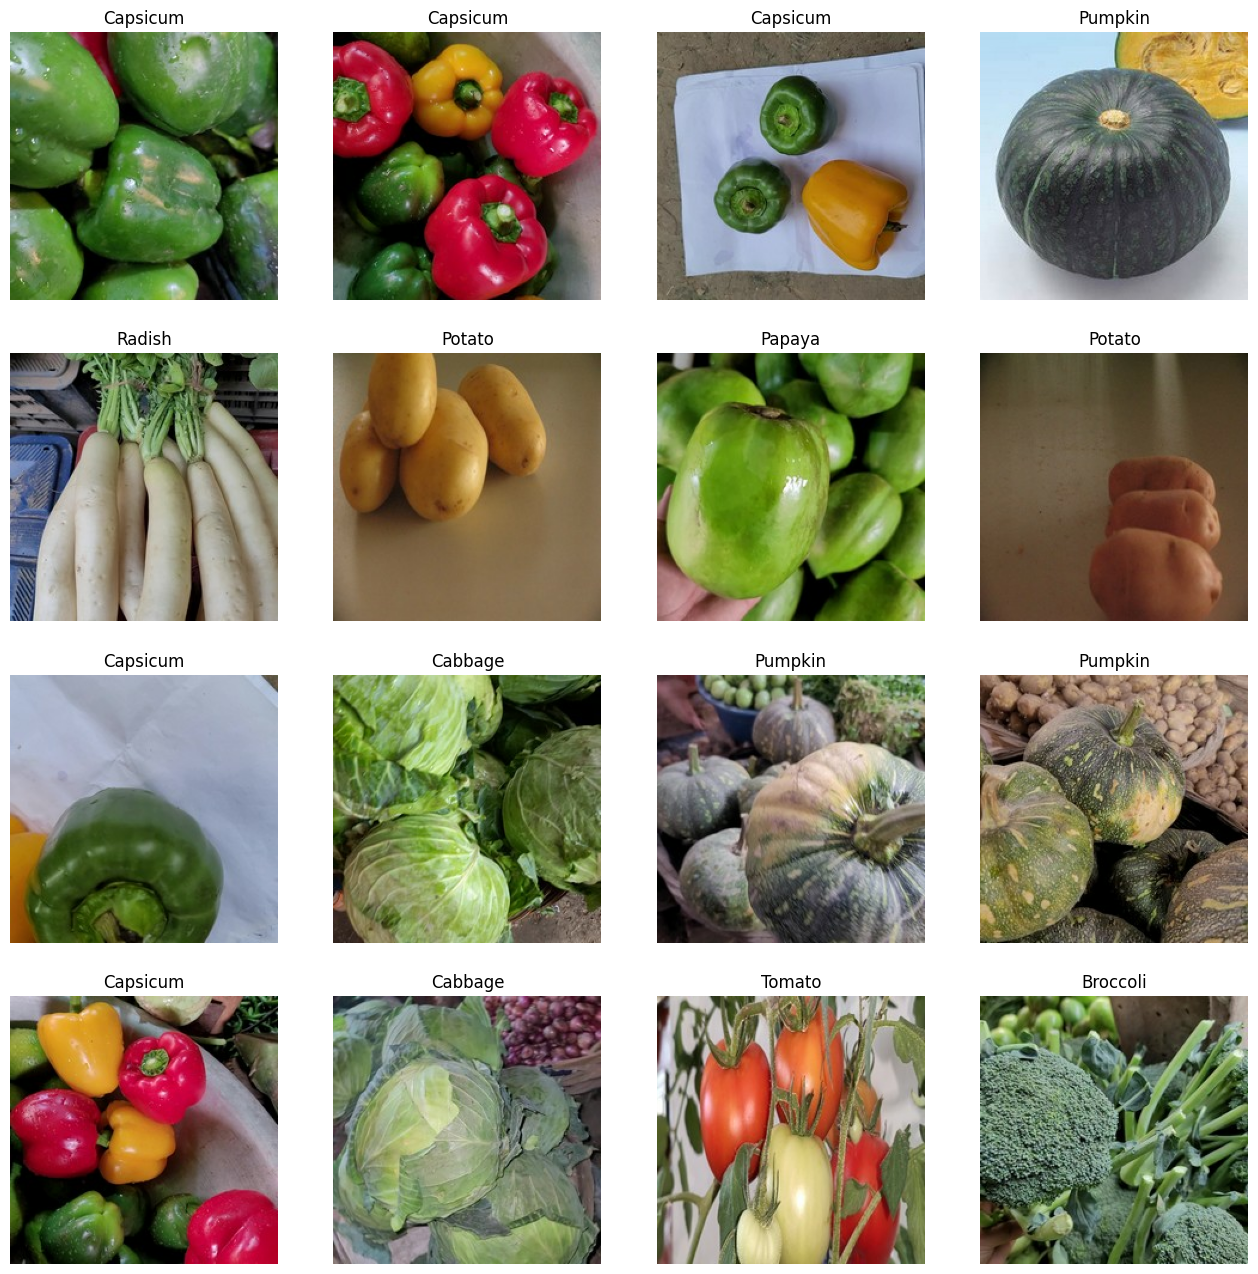

In [9]:
# Plot the Train Dataset
PlotDataset(train_ds, VEGETABLE_CLASS)

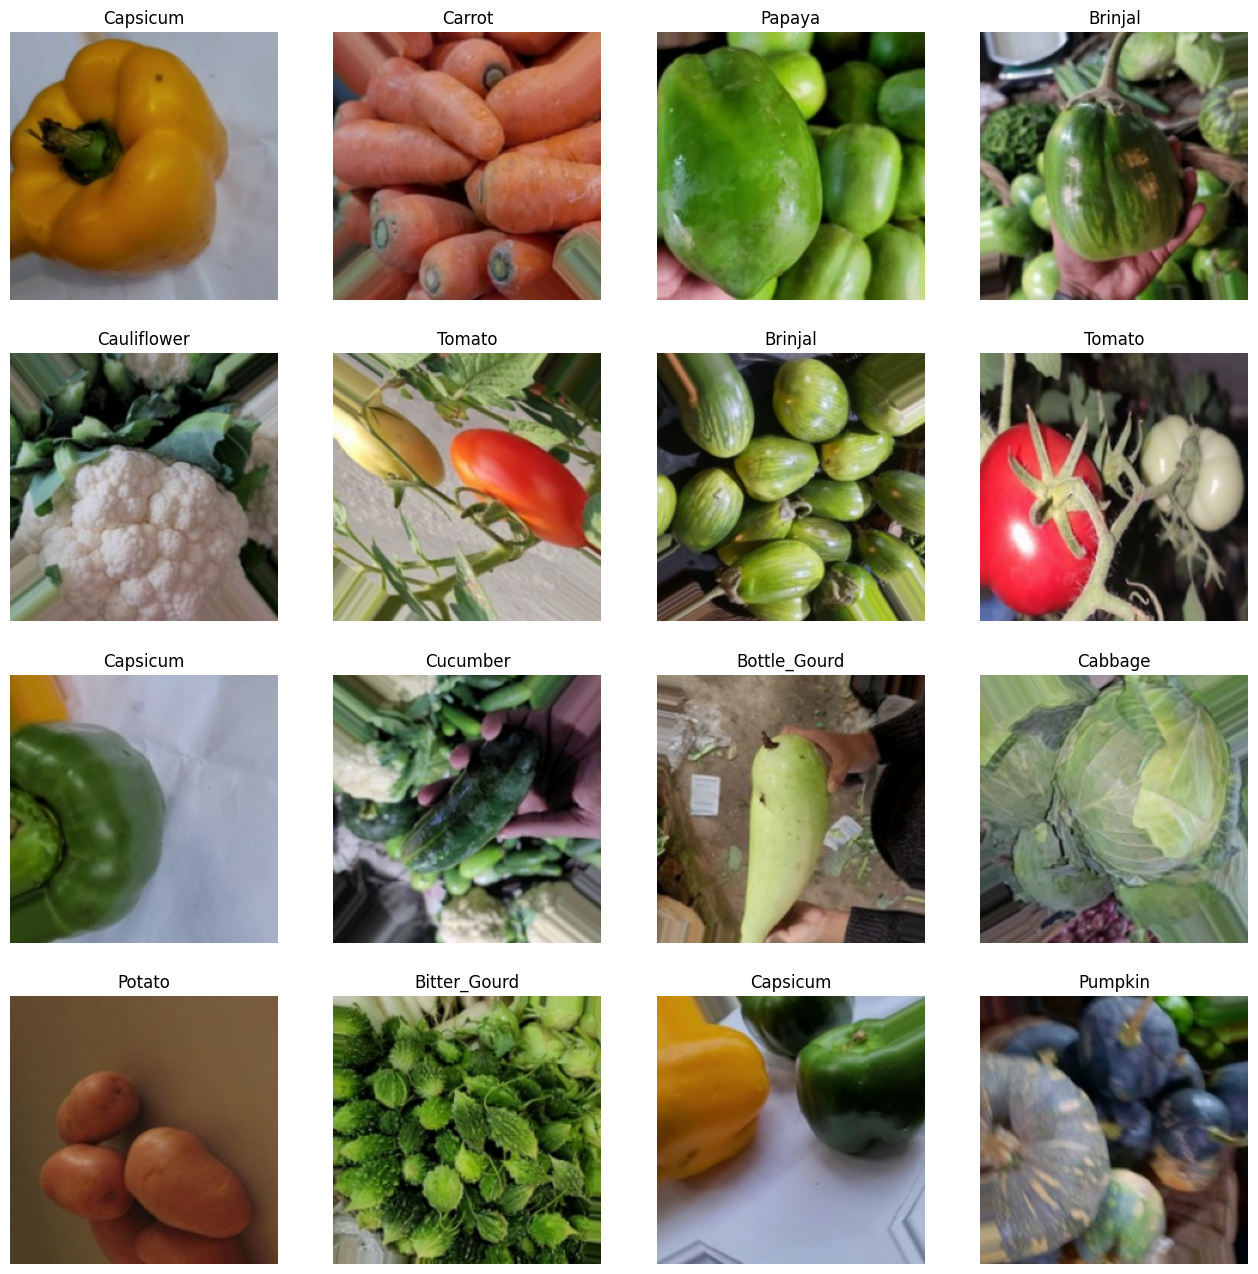

In [10]:
# Create Augmentation Layer and Test It
VEGETABLE_AUGMENTATION = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomZoom((0, -0.2), fill_mode='nearest', interpolation='bilinear'),
    keras.layers.RandomRotation((0, 1), fill_mode='nearest', interpolation='bilinear'),
], name='augmentation_layer')

aug_train_ds = train_ds.map(lambda x, y: (VEGETABLE_AUGMENTATION(x), y))
PlotDataset(aug_train_ds, VEGETABLE_CLASS)

In [11]:
## =============================
## Create Transfer Learning Layer and Preprocessing Layer for it
## =============================
if MODEL == "MobileNetV2":
  TL_LAYER = tf.keras.applications.mobilenet_v2.MobileNetV2(
                  include_top=False,
                  weights='imagenet',
                  input_shape=TL_INPUT_SHAPE,
                )
else:
  TL_LAYER = tf.keras.applications.xception.Xception(
                  include_top=False,
                  weights='imagenet',
                  input_shape=TL_INPUT_SHAPE,
                )
TL_LAYER.trainable = False

In [12]:
# Create a Model Builder with HyperParameter Tuner
def hyperparameter_model_builder(hp):
  global TL_INPUT_SHAPE
  global TL_LAYER
  global VEGETABLE_AUGMENTATION
  global CLASS_COUNT
  global MODEL

  input_layer = keras.Input(shape=TL_INPUT_SHAPE)

  # Preprocess will scale input pixels between -1 and 1.
  if MODEL == "MobileNetV2":
    x = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)
  else:
    x = tf.keras.applications.xception.preprocess_input(input_layer)
  
  x = TL_LAYER(x, training=False)
  x = VEGETABLE_AUGMENTATION(x)
  x = keras.layers.GlobalAveragePooling2D()(x)

  # Hyperparameters Layer
  # Create 2-3 Dense+Dropout Layer (Randomized)
  # With Dense value 64-512, and Dropout 0.2-0.6
  for i in range(0, hp.Int('num_layers',2,3)):
    x = keras.layers.Dense(name=f'dense_{i}', units=hp.Int(f'dense_{i}_units',min_value=64,max_value=512,step=64),activation='relu')(x)
    x = keras.layers.Dropout(name=f'dropout_{i}', rate=hp.Float(f'dropout_{i}_rates', min_value=0.2, max_value=0.6, step=0.2))(x)

  outputs = keras.layers.Dense(CLASS_COUNT, activation='softmax', name='output_plant_dense')(x)

  # Compile the Model
  vegetable_model = keras.Model(input_layer, outputs)
  vegetable_model.summary()

  # Hyperparameter For Learning Rate
  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
  vegetable_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-5), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
  )
  return vegetable_model

vegetable_model_tuner = RandomSearch(hyperparameter_model_builder,objective='val_accuracy',max_trials=10, executions_per_trial=1, directory='results', project_name=KERAS_TUNER_PROJECT)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 augmentation_layer (Sequent  (None, None, None, None)  0        
 ial)                                                        

In [13]:
# Use 3 callback, 
# - #1 to stop early (Callback will stop early if the val_loss is not decreasing in 5 interval)
# - #2 for logging on tensorboard, 
# - #3 for autosaving model after each trial

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

class autosaveModel(tf.keras.callbacks.Callback):
  global MODEL
  global DATASET_NAME
  def on_train_end(self, logs=None):
    model_version=max([int(i) for i in os.listdir(f'./models/{MODEL}/{DATASET_NAME}') + [0]])+1
    self.model.save(f"./models/{MODEL}/{DATASET_NAME}/{model_version}")

vegetable_model_tuner.search(
  train_ds,
  epochs=200,
  batch_size=32,
  validation_data=val_ds, 
  callbacks=[stop_early, keras.callbacks.TensorBoard(f"./tensorboard_logs/{MODEL}/{DATASET_NAME}"), autosaveModel()]
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |?                 |num_layers
384               |?                 |dense_0_units
0.2               |?                 |dropout_0_rates
512               |?                 |dense_1_units
0.2               |?                 |dropout_1_rates

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                 

d:\ubaya\TA\.natt\training\my-venv\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/augmentation_layer/random_zoom_1/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/augmentation_layer/random_zoom_1/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 7, 7, 1280), dtype=float32), dense_shape=Tensor("gradient_tape/model/augmentation_layer/random_zoom_1/loop_body/GatherV2/pfor/Cast:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


469/469 [==============================] - 81s 156ms/step - loss: 1.9808 - accuracy: 0.4794 - val_loss: 1.1597 - val_accuracy: 0.9313
Epoch 2/200
469/469 [==============================] - 75s 160ms/step - loss: 0.7274 - accuracy: 0.8846 - val_loss: 0.4008 - val_accuracy: 0.9690
Epoch 3/200
469/469 [==============================] - 79s 169ms/step - loss: 0.3232 - accuracy: 0.9417 - val_loss: 0.2025 - val_accuracy: 0.9823
Epoch 4/200
469/469 [==============================] - 98s 208ms/step - loss: 0.1972 - accuracy: 0.9598 - val_loss: 0.1287 - val_accuracy: 0.9857
Epoch 5/200
469/469 [==============================] - 105s 224ms/step - loss: 0.1390 - accuracy: 0.9729 - val_loss: 0.0910 - val_accuracy: 0.9900
Epoch 6/200
469/469 [==============================] - 111s 236ms/step - loss: 0.1037 - accuracy: 0.9779 - val_loss: 0.0682 - val_accuracy: 0.9923
Epoch 7/200
469/469 [==============================] - 103s 219ms/step - loss: 0.0809 - accuracy: 0.9827 - val_loss: 0.0537 - val_accu

FileNotFoundError: [WinError 3] The system cannot find the path specified: './models/MobileNetV2/20230704-dataset'

In [ ]:
# Building the Best Model from the previous training
# Also retrain it to max to see the ups and downs
best_hps=tuner.get_best_hyperparameters(num_trials=1)
model = tuner.hypermodel.build(best_hps[0])
history = model.fit(train_ds, validation_data=val_ds, epochs=200,verbose=1,batch_size=32)

In [ ]:
# See the best epoch
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch Loss : %d' % (best_epoch,))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch Acc: %d' % (best_epoch,))

In [ ]:
# Plot the training and validation accuracies for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title('Training and validation accuracy')
plt.show()

print("")
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(12, 6)) 
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(["Training Loss", "Validation Loss"])
plt.title('Training and validation loss')
plt.show()

In [ ]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hps[0])

# Retrain the model
hypermodel.fit(train_ds, validation_data=val_ds, epochs=best_epoch, batch_size=32)

In [ ]:
hypermodel.save(f"./models/{MODEL}/{DATATYPE}/best_model")